# Dependencies

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import random

from itertools import combinations

from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFECV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_selection import RFE

from IPython.display import display, clear_output

import pickle


# Functions

In [2]:
# function to run recursive feature elimination and output the reduced feature set
# function takes model input features (X_in), model output (y_in), number of features (N), 
# type of feature elimination (RFE or RFECV, sel) and verbosity (verb)
def feat_red(clf,X_in,y_in,N,sel,verb):
    estimator = clf
    if sel == 'RFECV':
        selector = RFECV(estimator, min_features_to_select=N, step=1,verbose=verb, cv = 3)
    else:
        selector = RFE(estimator,n_features_to_select=N,step=1,verbose=verb)
    selector = selector.fit(X_in,y_in)
    feat_out = selector.get_feature_names_out(X_in.columns)
    return feat_out

# runs feat_red function for all numbers of features in array N for input X (features) and y (model output)
# returns an array of feature sets for all specified N
def red_feats(clf,X_in,Y_in,N,sel):
    feat_r = {}
    feat_r[0] = X_in.columns
    j=1
    for i in N:
        feat_r[j]= feat_red(clf,X_in[feat_r[j-1]],Y_in,i,sel,0)
        j=j+1
    return feat_r

# function to compare classification methods
def comp_bin(X_train,Y_train):
    # Spot Check Algorithms
    models = []
    models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr', class_weight='balanced')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier(class_weight='balanced')))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(gamma='auto',class_weight='balanced')))
    models.append(('MLP', MLPClassifier(max_iter=1000)))
    models.append(('GB',GradientBoostingClassifier()))
    models.append(('RF',RandomForestClassifier(class_weight='balanced')))
    
    # evaluate each model in turn
    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        loo = LeaveOneOut()
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='balanced_accuracy')
        results.append(cv_results)
        names.append(name)
        print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
        
    # Compare Algorithms
    plt.boxplot(results, labels=names)
    plt.title('Algorithm Comparison')
    plt.ylabel('Balanced accuracy')
    plt.show()
    
    return results
    
def cm_test(clf,X,Y):
    clf.fit(X,Y)
    predictions = clf.predict(X)
    cm = confusion_matrix(Y, predictions, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
    disp.plot()

    plt.show()
    print(balanced_accuracy_score(Y,clf.predict(X)))
    
    # Comparison of feature sets

def feat_comp(clf,feat_r,X_train,Y_train):
    
    print('\n')

    results = []
    for i in feat_r:
    
        X_train2 = X_train[feat_r[i]]
    
        loo = LeaveOneOut()
        kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        cv_results = cross_val_score(clf, X_train2, Y_train, cv=kfold, scoring='balanced_accuracy')
        results.append(cv_results)
        print('%i: %f %f (%f)' % (i, feat_r[i].shape[0], cv_results.mean(), cv_results.std()))
    
    scores = [score.mean() for score in results]
    stdevs = [score.std() for score in results]
    scores_rev = scores[::-1]
    plt.scatter([1380]+N,scores)
    plt.ylabel('Balanced Accuracy')
    plt.xlabel('Number of features')
    
    return len(scores_rev) - np.argmax(scores_rev) - 1, scores, stdevs

def best_desc_comb(desc_rank,freq_thresh,n_desc,x_train,y_train,x_test,y_test):
    
    desc_rank_thresh = desc_rank[counts>freq_thresh]

    desc_comb =[]
    for comb in combinations(desc_rank_thresh,n_desc):
        desc_comb.append(comb)
    
    scores = []
    scores_test = []
    counter = 0
    for descs in desc_comb:
        X_train2 = x_train[list(descs)]
        X_test2 = x_test[list(descs)]
        clf = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight='balanced')
        clf.fit(X_train2,y_train)
        predictions = clf.predict(X_train2)
        scores.append(balanced_accuracy_score(y_train,clf.predict(X_train2)))
        scores_test.append(balanced_accuracy_score(y_test,clf.predict(X_test2)))
        counter = counter + 1
        clear_output(wait=True)
        display(str(counter)+'/'+str(len(desc_comb)))
    print('Maximum score of:',max(scores),' for ',desc_comb[np.argmax(scores)],' with test score of: ',scores_test[np.argmax(scores)])
    best_comb = list(desc_comb[np.argmax(scores)])
    
    return best_comb, max(scores), scores_test[np.argmax(scores)], desc_comb, scores

# Data Import

In [3]:
# import data on RG fluorescence
data = pd.read_csv('RG_for_ML.csv')
 
# Remove features with variance below threshold or correlated to each other

# Threshold for variance
threshold = 0;
X = data.drop(['RG','Group'],axis=1).select_dtypes(include='number');

scaler = preprocessing.MinMaxScaler()

X_scaled = X.copy()
X_scaled[X.columns] = scaler.fit_transform(X[X.columns])

selector = VarianceThreshold(threshold)
selector.fit(X)
X_reduced = X_scaled[X_scaled.columns[selector.get_support(indices=True)]]

# Correlation matrix
corr_matrix = X_reduced.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
X_reduced.drop(to_drop, axis=1, inplace=True)

Y = data['RG_binary']

/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [4]:
#x = X_reduced[data['Group'].isin([1,5])]
#y = Y[data['Group'].isin([1,5])]
#x = X_reduced[data['Group'].isin([1])]
#y = Y[data['Group'].isin([1])]
x=X_reduced
y=Y

# Compare binary classification methods

LR: 0.681410 (0.147806)
LDA: 0.552244 (0.147304)
KNN: 0.709295 (0.154193)
CART: 0.548077 (0.178039)
NB: 0.517308 (0.116353)
SVM: 0.695192 (0.194398)
MLP: 0.555449 (0.112828)
GB: 0.672756 (0.202185)
RF: 0.546154 (0.102556)


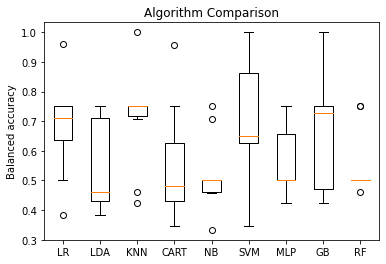

In [5]:
comp_bin_results = comp_bin(x,y)

In [6]:
comp_bin_df = pd.DataFrame(comp_bin_results)
comp_bin_df.to_csv('binary_method_comparison_results.csv')

# Run chosen classification method using all molecular descriptors

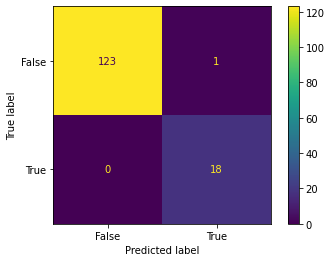

0.9959677419354839


In [7]:
clf = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight='balanced')
#clf = MLPClassifier()
cm_test(clf,x,y)

## Feature reduction for best method



0: 1784.000000 0.681410 (0.147806)
1: 1000.000000 0.764744 (0.177601)
2: 500.000000 0.848077 (0.195635)
3: 200.000000 0.876923 (0.177549)
4: 100.000000 0.901603 (0.174555)
5: 50.000000 0.901923 (0.186935)
6: 20.000000 0.889423 (0.182221)
7: 15.000000 0.889423 (0.182221)
8: 10.000000 0.935897 (0.075779)
9: 9.000000 0.911218 (0.061084)
10: 8.000000 0.915385 (0.062712)
11: 7.000000 0.848718 (0.163793)
12: 6.000000 0.886538 (0.064154)
13: 5.000000 0.882051 (0.066491)
14: 4.000000 0.886538 (0.067189)
15: 3.000000 0.870513 (0.061522)
16: 2.000000 0.883013 (0.083754)
17: 1.000000 0.850000 (0.087996)
Best number of descriptors =  10


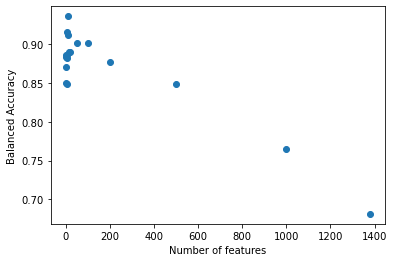

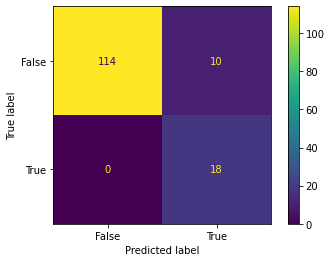

0.9596774193548387


In [8]:
N = [1000,500,200,100,50,20,15,10,9,8,7,6,5,4,3,2,1]
clf = LogisticRegression(solver='liblinear', multi_class='ovr', class_weight='balanced', max_iter=1000)
feat_r = red_feats(clf,x,y,N,'RFE')

N_best,scores,stdevs = feat_comp(clf,feat_r,x,y)
print('Best number of descriptors = ',N[N_best-1])
#N_best = 13;
cm_test(clf,x[feat_r[N_best]],y)

N_out = N
N_out.insert(0,1784)
LR_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
LR_scores.to_csv('LR_scores.csv')




0: 1784.000000 0.552244 (0.147304)
1: 1000.000000 0.713462 (0.184946)
2: 500.000000 0.729808 (0.113618)
3: 200.000000 0.706410 (0.148886)
4: 100.000000 0.809295 (0.173919)
5: 50.000000 0.842308 (0.171100)
6: 20.000000 0.734295 (0.159282)
7: 15.000000 0.713141 (0.185750)
8: 10.000000 0.663141 (0.202032)
9: 9.000000 0.667308 (0.203347)
10: 8.000000 0.667308 (0.203347)
11: 7.000000 0.667308 (0.203347)
12: 6.000000 0.667308 (0.203347)
13: 5.000000 0.667308 (0.203347)
14: 4.000000 0.567308 (0.120480)
15: 3.000000 0.567308 (0.120480)
16: 2.000000 0.567308 (0.120480)
17: 1.000000 0.567308 (0.120480)
Best number of descriptors =  50


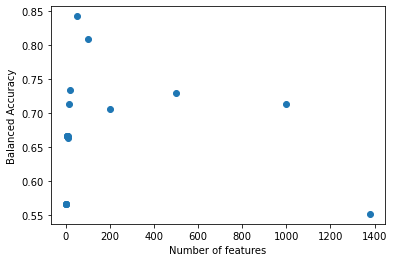

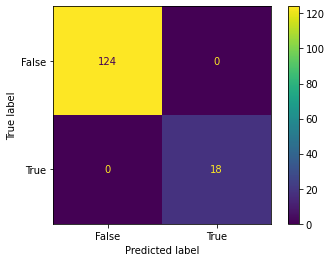

1.0


In [9]:
N = [1000,500,200,100,50,20,15,10,9,8,7,6,5,4,3,2,1]
clf = LinearDiscriminantAnalysis()
feat_r = red_feats(clf,x,y,N,'RFE')

N_best,scores,stdevs = feat_comp(clf,feat_r,x,y)
print('Best number of descriptors = ',N[N_best-1])
#N_best = 13;
cm_test(clf,x[feat_r[N_best]],y)

N_out = N
N_out.insert(0,1784)
LDA_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
LDA_scores.to_csv('LDA_scores.csv')

In [62]:
N = [1000,500,200,100,50,20,15,10,9,8,7,6,5,4,3,2,1]

clf = KNeighborsClassifier()
feat_r = red_feats_prefit(clf,x,y,N,'RFE')

N_best,scores,stdevs = feat_comp(clf,feat_r,x,y)
print('Best number of descriptors = ',N[N_best-1])
#N_best = 13;
cm_test(clf,x[feat_r[N_best]],y)

N_out = N
N_out.insert(0,1784)
KNN_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
KNN_scores.to_csv('KNN_scores.csv')

ValueError: when `importance_getter=='auto'`, the underlying estimator KNeighborsClassifier should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.



0: 1784.000000 0.568269 (0.162428)
1: 1000.000000 0.623077 (0.193236)
2: 500.000000 0.490385 (0.160788)
3: 200.000000 0.622756 (0.192041)
4: 100.000000 0.660897 (0.247231)
5: 50.000000 0.834295 (0.208920)
6: 20.000000 0.859295 (0.180437)
7: 15.000000 0.867308 (0.174025)
8: 10.000000 0.867308 (0.174025)
9: 9.000000 0.842308 (0.204390)
10: 8.000000 0.867308 (0.174025)
11: 7.000000 0.867308 (0.174025)
12: 6.000000 0.842308 (0.204390)
13: 5.000000 0.863141 (0.204537)
14: 4.000000 0.804487 (0.237474)
15: 3.000000 0.754808 (0.238786)
16: 2.000000 0.693269 (0.205998)
17: 1.000000 0.735256 (0.214107)
Best number of descriptors =  7


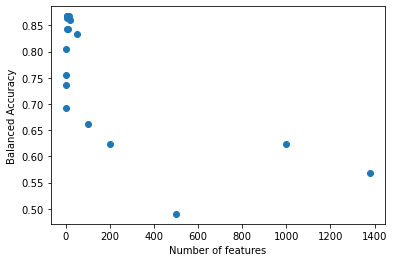

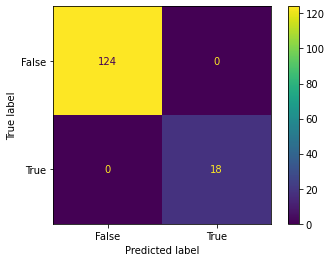

1.0


In [10]:
N = [1000,500,200,100,50,20,15,10,9,8,7,6,5,4,3,2,1]

clf=DecisionTreeClassifier(class_weight='balanced')
feat_r = red_feats(clf,x,y,N,'RFE')

N_best,scores,stdevs = feat_comp(clf,feat_r,x,y)
print('Best number of descriptors = ',N[N_best-1])
#N_best = 13;
cm_test(clf,x[feat_r[N_best]],y)

N_out = N
N_out.insert(0,1784)
DT_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
DT_scores.to_csv('DT_scores.csv')

In [55]:
N = [1000,500,200,100,50,20,15,10,9,8,7,6,5,4,3,2,1]

clf=GaussianNB()
feat_r = red_feats(clf,x,y,N,'RFE')

N_best,scores,stdevs = feat_comp(clf,feat_r,x,y)
print('Best number of descriptors = ',N[N_best-1])
#N_best = 13;
cm_test(clf,x[feat_r[N_best]],y)

N_out = N
N_out.insert(0,1784)
NB_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
NB_scores.to_csv('NB_scores.csv')


ValueError: when `importance_getter=='auto'`, the underlying estimator GaussianNB should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [57]:
N = [1000,500,200,100,50,20,15,10,9,8,7,6,5,4,3,2,1]

clf=SVC(gamma='auto',class_weight='balanced')
feat_r = red_feats(clf,x,y,N,'RFE')

N_best,scores,stdevs = feat_comp(clf,feat_r,x,y)
print('Best number of descriptors = ',N[N_best-1])
#N_best = 13;
cm_test(clf,x[feat_r[N_best]],y)

N_out = N
N_out.insert(0,1784)
SVC_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
SVC_scores.to_csv('SVC_scores.csv')

ValueError: when `importance_getter=='auto'`, the underlying estimator SVC should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [58]:
N = [1000,500,200,100,50,20,15,10,9,8,7,6,5,4,3,2,1]


clf=MLPClassifier(max_iter=1000)
feat_r = red_feats(clf,x,y,N,'RFE')

N_best,scores,stdevs = feat_comp(clf,feat_r,x,y)
print('Best number of descriptors = ',N[N_best-1])
#N_best = 13;
cm_test(clf,x[feat_r[N_best]],y)

N_out = N
N_out.insert(0,1784)
MLP_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
MLP_scores.to_csv('MLP_scores.csv')

ValueError: when `importance_getter=='auto'`, the underlying estimator MLPClassifier should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.



0: 1784.000000 0.672436 (0.206828)
1: 1000.000000 0.693269 (0.224080)
2: 500.000000 0.759295 (0.194541)
3: 200.000000 0.788462 (0.206227)
4: 100.000000 0.896154 (0.119850)
5: 50.000000 0.867308 (0.174025)
6: 20.000000 0.896154 (0.119850)
7: 15.000000 0.896154 (0.119850)
8: 10.000000 0.896154 (0.119850)
9: 9.000000 0.896154 (0.119850)
10: 8.000000 0.896154 (0.119850)
11: 7.000000 0.896154 (0.119850)
12: 6.000000 0.896154 (0.119850)
13: 5.000000 0.896154 (0.119850)
14: 4.000000 0.896154 (0.119850)
15: 3.000000 0.772436 (0.155896)
16: 2.000000 0.747115 (0.172759)
17: 1.000000 0.615705 (0.146116)
Best number of descriptors =  4


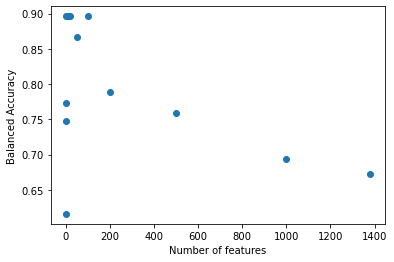

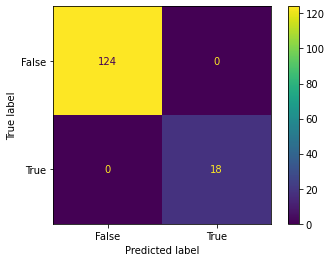

1.0


In [11]:
N = [1000,500,200,100,50,20,15,10,9,8,7,6,5,4,3,2,1]

clf=GradientBoostingClassifier()
feat_r = red_feats(clf,x,y,N,'RFE')

N_best,scores,stdevs = feat_comp(clf,feat_r,x,y)
print('Best number of descriptors = ',N[N_best-1])
#N_best = 13;
cm_test(clf,x[feat_r[N_best]],y)

N_out = N
N_out.insert(0,1784)
GB_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
GB_scores.to_csv('GB_scores.csv')



0: 1784.000000 0.541987 (0.105160)
1: 1000.000000 0.542308 (0.104909)
2: 500.000000 0.566987 (0.120765)
3: 200.000000 0.592308 (0.171100)
4: 100.000000 0.592308 (0.171100)
5: 50.000000 0.671154 (0.199008)
6: 20.000000 0.658974 (0.224433)
7: 15.000000 0.634295 (0.208074)
8: 10.000000 0.605128 (0.205352)
9: 9.000000 0.601282 (0.218115)
10: 8.000000 0.675962 (0.193163)
11: 7.000000 0.596795 (0.210939)
12: 6.000000 0.596795 (0.178873)
13: 5.000000 0.572115 (0.178806)
14: 4.000000 0.629808 (0.180351)
15: 3.000000 0.642628 (0.154747)
16: 2.000000 0.643269 (0.185466)
17: 1.000000 0.615705 (0.146116)
Best number of descriptors =  8


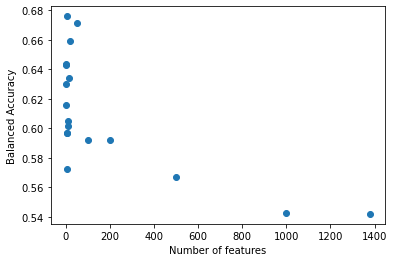

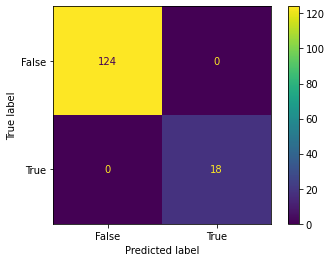

1.0


In [12]:
N = [1000,500,200,100,50,20,15,10,9,8,7,6,5,4,3,2,1]

clf=RandomForestClassifier(class_weight='balanced')
feat_r = red_feats(clf,x,y,N,'RFE')

N_best,scores,stdevs = feat_comp(clf,feat_r,x,y)
print('Best number of descriptors = ',N[N_best-1])
#N_best = 13;
cm_test(clf,x[feat_r[N_best]],y)

N_out = N
N_out.insert(0,1784)
RF_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
RF_scores.to_csv('RF_scores.csv')



0: 1784.000000 0.681410 (0.147806)
1: 1000.000000 0.764744 (0.177601)
2: 862.000000 0.814744 (0.184331)
3: 467.000000 0.851923 (0.186657)
4: 407.000000 0.851923 (0.186657)
5: 371.000000 0.851923 (0.186657)
6: 303.000000 0.851923 (0.186657)
7: 269.000000 0.848077 (0.195635)
8: 222.000000 0.876923 (0.177549)
9: 160.000000 0.884615 (0.181015)
10: 150.000000 0.884615 (0.181015)
11: 141.000000 0.880769 (0.178919)
12: 135.000000 0.880769 (0.178919)
13: 119.000000 0.909615 (0.177934)
14: 111.000000 0.901923 (0.175506)
15: 110.000000 0.905769 (0.177184)
16: 108.000000 0.905769 (0.176347)
17: 107.000000 0.901923 (0.175506)
18: 103.000000 0.905769 (0.176347)
19: 98.000000 0.905769 (0.176347)
20: 94.000000 0.909615 (0.177934)
21: 91.000000 0.909615 (0.177934)
22: 90.000000 0.905769 (0.176347)
23: 88.000000 0.909615 (0.177934)
24: 76.000000 0.909615 (0.177934)
25: 70.000000 0.909615 (0.177934)
26: 68.000000 0.905449 (0.176249)
N_best =  25


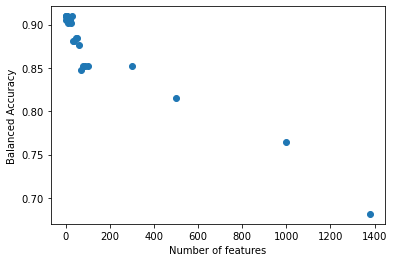

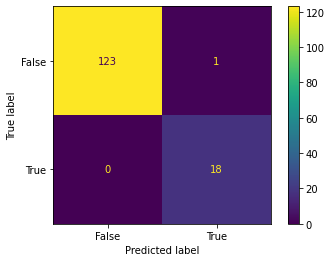

0.9959677419354839


In [15]:
N = [1000,500,300,100,90,80,70,60,50,45,40,35,30,25,20,15,10,9,8,7,6,5,4,3,2,1]
clf=
feat_r = red_feats(clf,x,y,N,'RFECV')

N_best = feat_comp(clf,feat_r,x,y)
print('N_best = ',N_best)
#N_best = 13;
cm_test(clf,x[feat_r[N_best]],y)

In [16]:
test_molecules = pd.read_csv('descriptors_test_compounds.csv')
molecules = pd.read_csv('smiles_for_descriptors.csv')
molecules['experimental'] = [True,True,False,False,True,False,True,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True]

test_molecules[X.columns] = scaler.transform(test_molecules[X.columns])
test_molecules = test_molecules[X_reduced.columns]

test_predict = clf.predict(test_molecules[feat_r[N_best]])
molecules['prediction'] = test_predict
molecules

,Name,SMILES,experimental,prediction
0,Amiodarone,CCCCC1=C(C2=CC=CC=C2O1)C(=O)C3=CC(=C(C(=C3)I)O...,True,True
1,Apilimod,CC1=CC(=CC=C1)C=NNC2=CC(=NC(=N2)OCCC3=CC=CC=N3...,True,False
2,Chlorpromazine,CN(C)CCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl,False,False
3,Emetine,CCC1CN2CCC3=CC(=C(C=C3C2CC1CC4C5=CC(=C(C=C5CCN...,False,False
4,Emetine analog,CC[C@@H]1[C@@H](C[C@H](C2=C3)N(CCCCCCCC/C=C\CC...,True,True
5,Levofloxacin,CC1COC2=C3N1C=C(C(=O)C3=CC(=C2N4CCN(CC4)C)F)C(...,False,False
6,MC3,CCCCCC=CCC=CCCCCCCCCC(CCCCCCCCC=CCC=CCCCCC)OC(...,True,True
7,Netarsudil,CC1=CC(=C(C=C1)C(=O)OCC2=CC=C(C=C2)C(CN)C(=O)N...,True,False
8,Siramesine,C1CN(CCC12C3=CC=CC=C3CO2)CCCCC4=CN(C5=CC=CC=C5...,True,True
9,Sorafenib,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...,False,True


In [18]:
test_molecules['Name'] = molecules['Name']
test_molecules['Experimental'] = molecules['experimental']
test_molecules_2 = test_molecules[test_molecules['Name'].isin(['Apilimod','Chlorpromazine','Emetine','Levofloxacin','MC3','Siramesine','Sorafenib','Timolol','7a','7b','7c','7d','7e','7f','7g','7h','7i','7j','7k','7l','7m'])]
test_molecules_3 = test_molecules[test_molecules['Name'].isin(['Apilimod','Chlorpromazine','Emetine','Levofloxacin','MC3','Siramesine','Sorafenib','7a','7b','7c','7d','7e','7f','7g','7h','7i','7j','7k','7l','7m'])]

In [20]:
test_predict = clf.predict(test_molecules_3[feat_r[N_best]])
test_predict

array([False, False, False, False,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False])

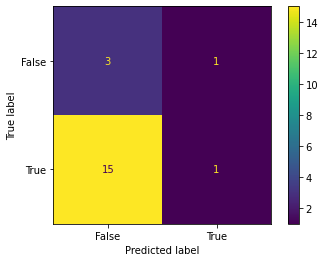

0.40625


In [68]:
predictions = clf.predict(test_molecules_3[feat_r[N_best]])
cm = confusion_matrix(test_molecules_3['Experimental'], predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

plt.show()
print(balanced_accuracy_score(test_molecules_3['Experimental'],clf.predict(test_molecules_3[feat_r[N_best]])))


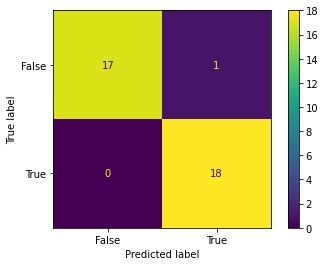

0.9722222222222222
0 ['SaaaC' 'NaaaC' 'B02[O-O]' 'B03[N-O]' 'B03[N-S]' 'B04[N-O]' 'B08[N-N]'
 'B09[C-F]' 'CMC-80' 'Infective-80']


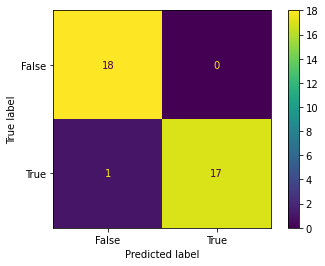

0.9722222222222222
1 ['PCR' 'P_VSA_ppp_L' 'Mor32m' 'Mor27v' 'Mor32v' 'N-073' 'ALOGP2' 'CMC-80'
 'Depressant-80' 'Infective-80']


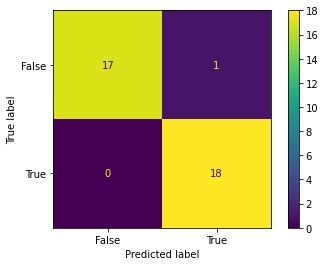

0.9722222222222222
2 ['P_VSA_charge_10' 'C-026' 'SaaaC' 'NaaaC' 'B03[C-N]' 'B04[C-S]'
 'B04[N-O]' 'B05[N-F]' 'Depressant-80' 'Infective-80']


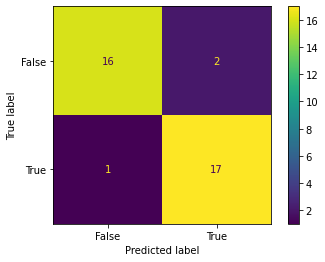

0.9166666666666666
3 ['nR07' 'NaaaC' 'B03[N-O]' 'B04[N-Cl]' 'B07[N-Cl]' 'B08[C-F]' 'ALOGP2'
 'CMC-80' 'Infective-80' 'nLevel6']


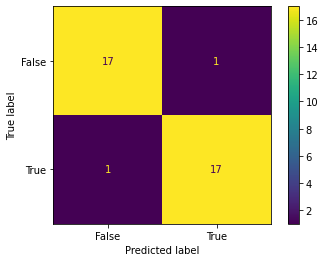

0.9444444444444444
4 ['Mor32m' 'H-051' 'NaaaC' 'B03[C-N]' 'B05[N-F]' 'B08[O-O]' 'B09[C-N]'
 'B10[C-N]' 'Ro5' 'Depressant-80']


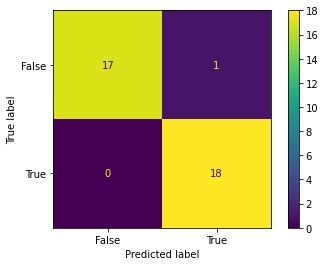

0.9722222222222222
5 ['B02[O-O]' 'B03[N-O]' 'B03[N-S]' 'B04[N-O]' 'B07[N-O]' 'B09[C-N]'
 'B10[O-O]' 'Ro5' 'CMC-80' 'Infective-80']


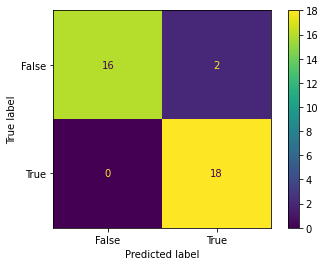

0.9444444444444444
6 ['nAA' 'PCD' 'SpMax1_Bh(e)' 'Mor32m' 'Mor27v' 'Mor27s' 'B03[N-N]'
 'B09[C-N]' 'CMC-80' 'Neoplastic-80']


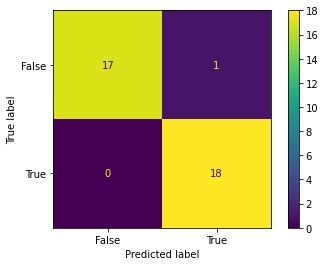

0.9722222222222222
7 ['Mor32m' 'Mor32v' 'minssO' 'B04[N-O]' 'B05[N-F]' 'B07[N-S]' 'B07[N-Cl]'
 'B08[C-F]' 'B08[O-O]' 'B10[C-N]']


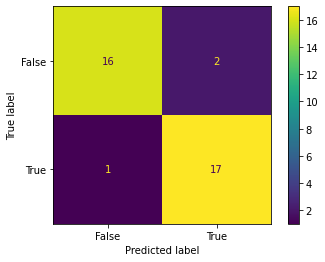

0.9166666666666666
8 ['P_VSA_charge_14' 'Mor25m' 'nCq' 'B01[N-O]' 'B02[O-O]' 'B03[N-O]'
 'Depressant-80' 'Neoplastic-80' 'Infective-80' 'MDEN-22']


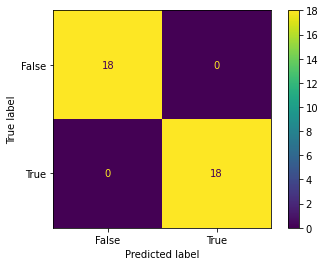

1.0
9 ['Mor25m' 'NaaaC' 'B02[O-O]' 'B04[N-O]' 'B07[N-O]' 'B08[O-O]' 'B10[C-N]'
 'Depressant-80' 'Neoplastic-80' 'Infective-80']


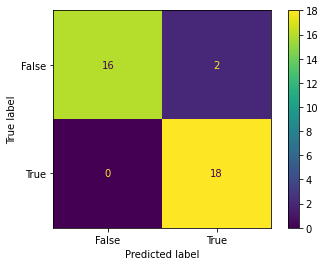

0.9444444444444444
10 ['nSpiro' 'nBridgeHead' 'EE_Dt' 'Mor32m' 'Mor27v' 'B03[N-O]' 'B07[C-S]'
 'B09[C-N]' 'B09[Cl-Cl]' 'CMC-80']


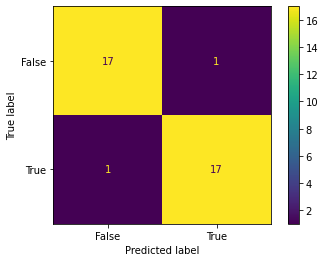

0.9444444444444444
11 ['nAA' 'Mor25m' 'C-003' 'NaaaC' 'B04[O-O]' 'B10[C-Cl]' 'B10[N-O]' 'ALOGP2'
 'CMC-80' 'Infective-80']


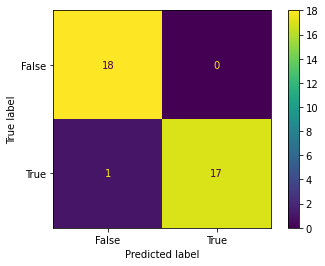

0.9722222222222222
12 ['DISPp' 'Mor32m' 'H-049' 'NaaaC' 'minssO' 'B03[N-O]' 'B04[N-O]'
 'B09[N-O]' 'B10[C-Cl]' 'Infective-80']


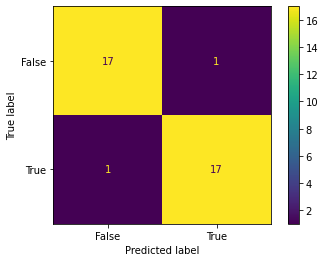

0.9444444444444444
13 ['Mor32m' 'Mor27v' 'nCt' 'NaaaC' 'B03[N-N]' 'B07[N-O]' 'B09[C-N]' 'ALOGP2'
 'CMC-80' 'Infective-80']


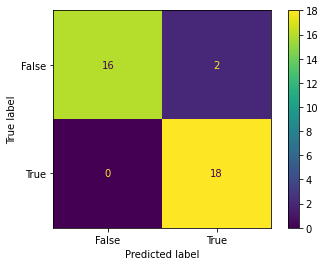

0.9444444444444444
14 ['Eta_sh_x' 'N-073' 'minssNH' 'B02[N-O]' 'B09[C-N]' 'B10[C-N]' 'B10[N-N]'
 'Depressant-80' 'Infective-80' 's4_numAroBonds']


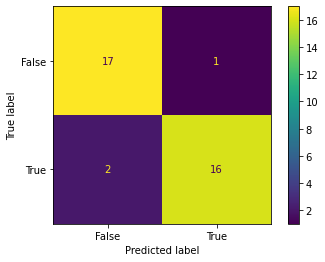

0.9166666666666666
15 ['VE1sign_Dz(v)' 'P_VSA_charge_10' 'Mor32m' 'H-049' 'mindO' 'B03[N-O]'
 'B05[N-F]' 'CMC-80' 'Infective-80' 's4_numAroBonds']


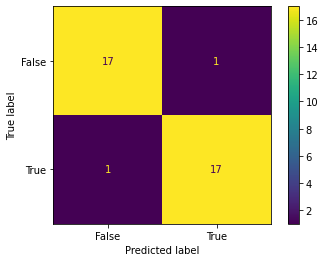

0.9444444444444444
16 ['Mor30v' 'SaaaC' 'NaaaC' 'minaaaC' 'minssO' 'B02[N-O]' 'B08[O-O]'
 'CMC-80' 'Psychotic-80' 'Infective-80']


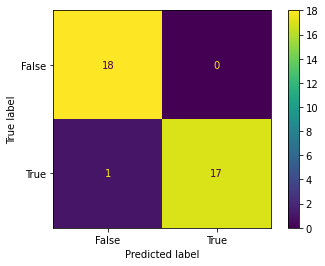

0.9722222222222222
17 ['P_VSA_charge_10' 'Mor32m' 'NaaaC' 'B04[N-O]' 'B04[O-O]' 'B09[C-N]'
 'ALOGP2' 'CMC-80' 'Infective-80' 's3_numSharedNeighbors']


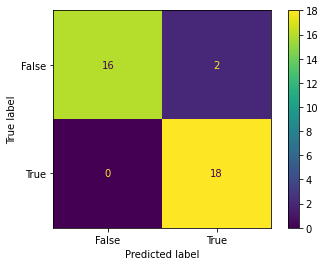

0.9444444444444444
18 ['SM03_EA(dm)' 'Mor32m' 'Mor18v' 'Mor30v' 'Mor32v' 'C-026' 'B02[N-N]'
 'B02[O-O]' 'B09[C-N]' 'B10[C-N]']


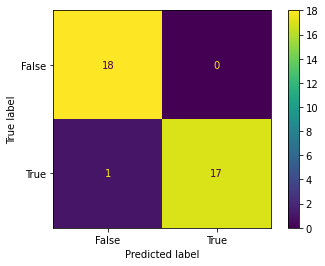

0.9722222222222222
19 ['Mor25m' 'Mor32m' 'Mor32v' 'C-026' 'B02[O-O]' 'B03[N-S]' 'B08[C-O]'
 'B10[C-N]' 'Ro5' 'CMC-80']


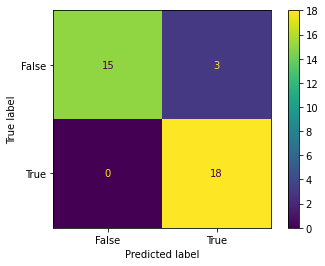

0.9166666666666667
20 ['P_VSA_charge_10' 'DISPv' 'DISPp' 'Mor27u' 'Mor32m' 'Mor25v' 'Mor27v'
 'NaaaC' 'B08[O-O]' 'Infective-80']


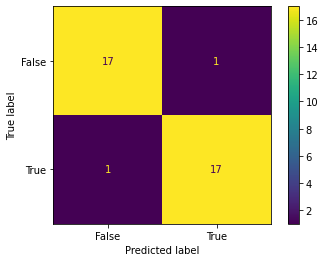

0.9444444444444444
21 ['Mor32m' 'Mor27v' 'Mor32v' 'minsOH' 'minssO' 'B02[O-O]' 'B08[C-O]'
 'ALOGP2' 'Depressant-80' 'Infective-80']


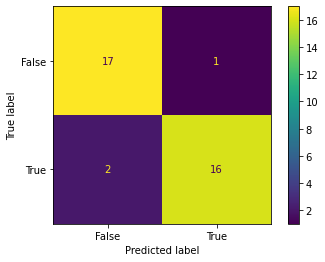

0.9166666666666666
22 ['VE1sign_X' 'Mor25m' 'Mor32m' 'C-026' 'B02[O-O]' 'B03[N-O]' 'CMC-80'
 'Infective-80' 'MDEN-22' 's3_numSharedNeighbors']


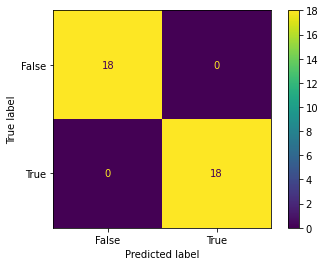

1.0
23 ['Mor20m' 'Mor25m' 'Mor32m' 'Mor32v' 'C-026' 'NaaaC' 'B08[O-O]' 'CMC-80'
 'Depressant-80' 'Hypertens-80']


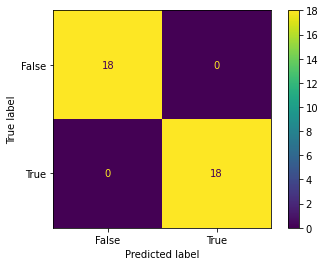

1.0
24 ['Mor27u' 'Mor20m' 'Mor27v' 'C-003' 'C-026' 'NaaaC' 'B03[N-N]' 'B09[C-N]'
 'CMC-80' 'Infective-80']


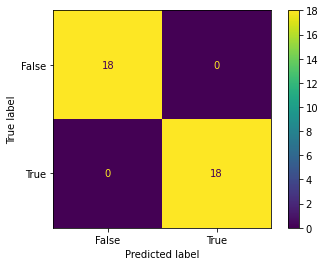

1.0
25 ['VE1sign_RG' 'Mor32m' 'NaaaC' 'B02[O-O]' 'B04[O-O]' 'B08[N-N]' 'B08[O-O]'
 'B09[C-N]' 'CMC-80' 'Infective-80']


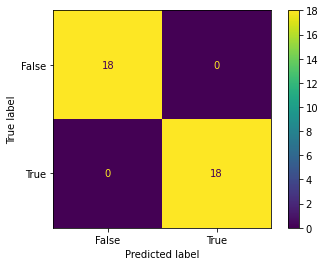

1.0
26 ['Mor25m' 'Mor32m' 'nArOR' 'NaaaC' 'B04[N-O]' 'B09[C-N]' 'B09[N-O]'
 'B10[C-Cl]' 'Depressant-80' 'Infective-80']


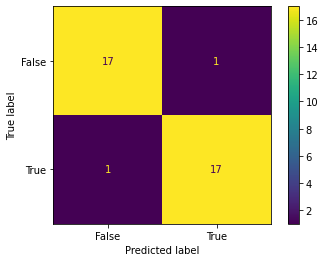

0.9444444444444444
27 ['VE1sign_X' 'SpMAD_AEA(bo)' 'NaaaC' 'minaaN' 'B03[N-O]' 'B04[N-O]'
 'B06[C-S]' 'B09[C-N]' 'CMC-80' 'MDEN-22']


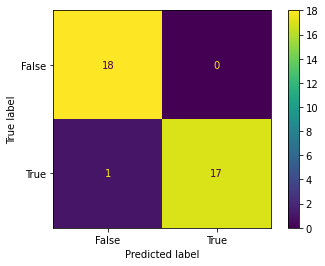

0.9722222222222222
28 ['P_VSA_charge_10' 'Mor32m' 'Mor27v' 'nArCONR2' 'C-026' 'mindO' 'minsCl'
 'B10[C-N]' 'Infective-80' 'MDEN-22']


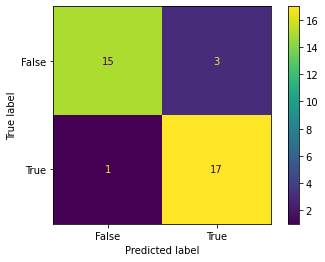

0.8888888888888888
29 ['Mor32m' 'Mor18v' 'Mor32v' 'N-071' 'minaaN' 'B03[N-O]' 'B09[C-N]'
 'B10[C-N]' 'ALOGP2' 'Infective-80']


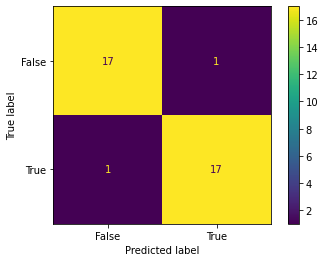

0.9444444444444444
30 ['NRS' 'EE_Dt' 'Mor18v' 'NaaaC' 'B03[C-N]' 'B04[N-O]' 'B06[C-S]'
 'B10[C-N]' 'B10[N-N]' 'Infective-80']


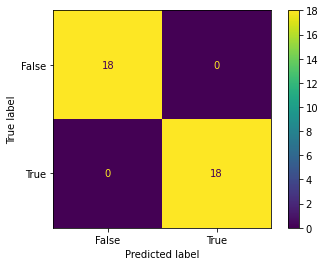

1.0
31 ['Mor25m' 'Mor32m' 'C-026' 'B02[O-O]' 'B03[N-O]' 'B07[N-O]' 'B08[O-O]'
 'CMC-80' 'Infective-80' 's4_numAroBonds']


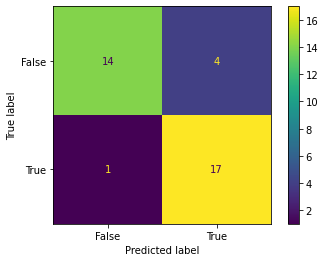

0.8611111111111112
32 ['D/Dtr11' 'VE2sign_B(s)' 'H-051' 'NaaaC' 'B03[N-N]' 'B09[C-N]' 'ALOGP2'
 'CMC-80' 'Hypertens-80' 'Infective-80']


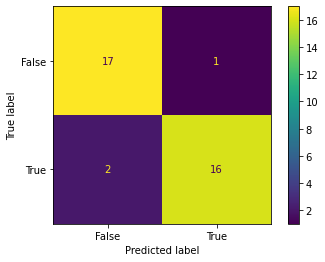

0.9166666666666666
33 ['B03[N-O]' 'B04[S-Cl]' 'B07[N-O]' 'B09[C-N]' 'B10[C-N]' 'B10[C-O]'
 'CMC-80' 'Hypertens-80' 'Neoplastic-80' 'Infective-80']


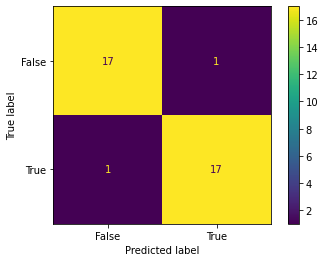

0.9444444444444444
34 ['NRS' 'VE1sign_Dz(v)' 'P_VSA_charge_10' 'Mor27u' 'Mor20m' 'Mor32m'
 'Mor27v' 'C-026' 'CMC-80' 'Infective-80']


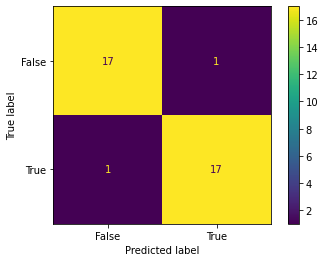

0.9444444444444444
35 ['NRS' 'NaaaC' 'B03[C-N]' 'B03[N-N]' 'B05[N-F]' 'B08[N-N]' 'B08[O-O]'
 'B10[C-N]' 'Depressant-80' 'Infective-80']


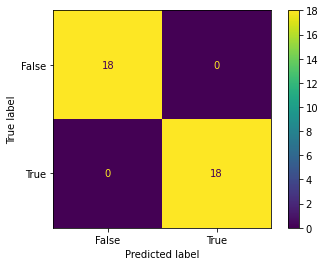

1.0
36 ['Mor32m' 'minsNH2' 'minssO' 'B03[N-O]' 'B06[O-O]' 'B09[C-F]' 'B09[N-O]'
 'Depressant-80' 'Infective-80' 's4_numAroBonds']


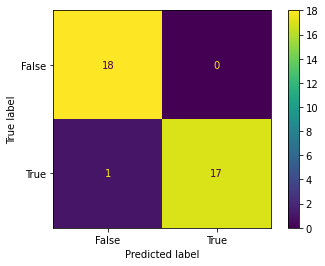

0.9722222222222222
37 ['P_VSA_charge_10' 'Mor32m' 'NaaaC' 'minssO' 'B03[N-O]' 'B04[N-O]'
 'B05[N-F]' 'B08[O-O]' 'Psychotic-80' 'Infective-80']


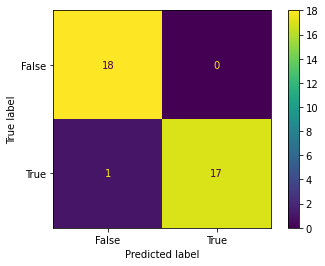

0.9722222222222222
38 ['C-026' 'NaaaC' 'B02[O-O]' 'B03[N-O]' 'B06[O-O]' 'ALOGP2' 'CMC-80'
 'Depressant-80' 'Infective-80' 'MDEN-22']


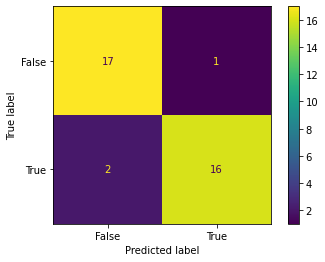

0.9166666666666666
39 ['nAA' 'P_VSA_charge_7' 'P_VSA_charge_14' 'Mor32m' 'Mor32v' 'B04[O-O]'
 'B09[C-S]' 'B10[C-N]' 'ALOGP2' 'CMC-80']


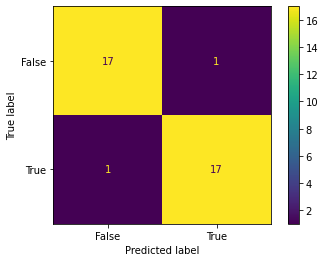

0.9444444444444444
40 ['nAA' 'nBnz' 'VE1sign_RG' 'Mor32m' 'Mor32v' 'B02[O-O]' 'B08[N-N]'
 'ALOGP2' 'CMC-80' 'Infective-80']


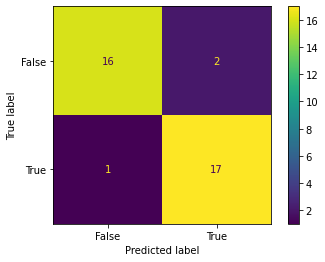

0.9166666666666666
41 ['Mor32m' 'NaaaC' 'CATS2D_04_DP' 'B05[N-F]' 'B05[O-S]' 'B09[C-N]'
 'B10[O-O]' 'ALOGP2' 'CMC-80' 'Infective-80']


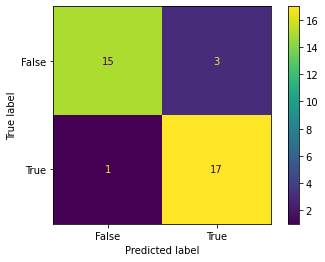

0.8888888888888888
42 ['nAA' 'VE1sign_RG' 'Mor32m' 'Mor27v' 'Mor32v' 'B06[O-O]' 'B10[C-N]'
 'ALOGP2' 'Depressant-80' 'Neoplastic-80']


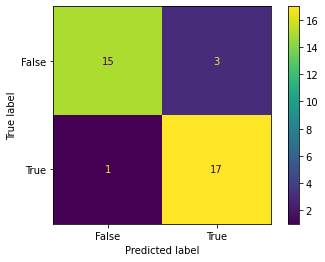

0.8888888888888888
43 ['nAA' 'P_VSA_charge_10' 'Mor32u' 'Mor32m' 'Mor32v' 'nCb-' 'B09[C-N]'
 'CMC-80' 'Depressant-80' 's2_phSize']


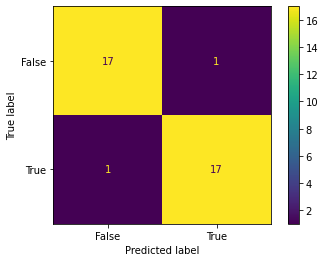

0.9444444444444444
44 ['NRS' 'Mor25m' 'Mor32m' 'Mor25v' 'Mor27v' 'Mor32v' 'B05[O-O]' 'B09[C-N]'
 'CMC-80' 'Infective-80']


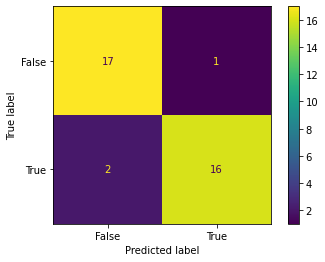

0.9166666666666666
45 ['P_VSA_ppp_L' 'P_VSA_charge_10' 'Mor32m' 'Mor30v' 'NaaaC' 'mindO'
 'minsCl' 'B02[O-O]' 'CMC-80' 'Neoplastic-80']


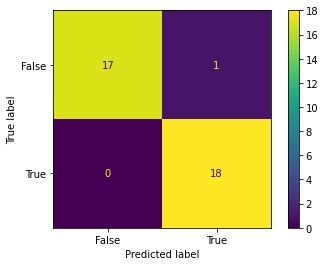

0.9722222222222222
46 ['Mor32m' 'Mor27v' 'Mor32v' 'N-073' 'mindsCH' 'minssO' 'B03[N-O]'
 'B09[C-N]' 'ALOGP2' 'Infective-80']


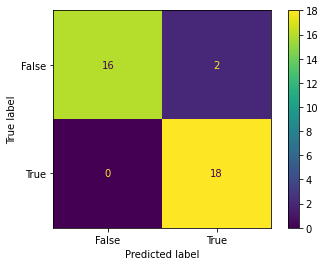

0.9444444444444444
47 ['PCR' 'Mor32m' 'Mor32v' 'NaaaC' 'B01[C-S]' 'B02[O-O]' 'B09[C-N]' 'ALOGP2'
 'CMC-80' 'MDEN-22']


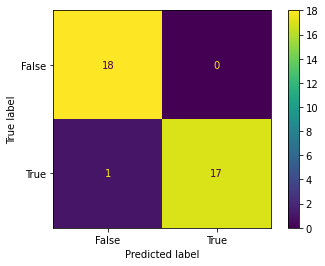

0.9722222222222222
48 ['nRCOOR' 'NaaaC' 'minssO' 'B02[O-O]' 'B06[O-O]' 'B08[O-O]' 'B09[C-N]'
 'CMC-80' 'Infective-80' 'MDEN-22']


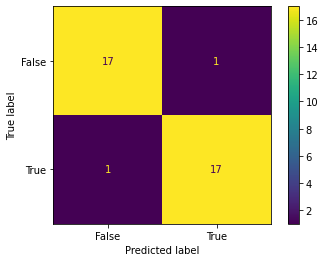

0.9444444444444444
49 ['Eta_sh_x' 'SpMAD_EA(ri)' 'Mor25m' 'Mor32m' 'C-026' 'B04[N-N]' 'B07[N-N]'
 'B10[C-N]' 'B10[C-Cl]' 'CMC-80']


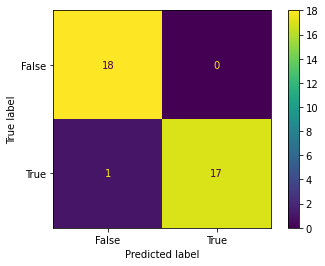

0.9722222222222222
50 ['minaaNH' 'minssO' 'B02[O-O]' 'B04[N-O]' 'B09[C-N]' 'B09[N-O]' 'B10[C-N]'
 'B10[C-Cl]' 'DLS_05' 'Infective-80']


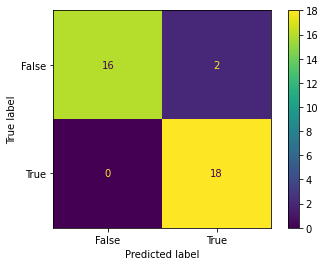

0.9444444444444444
51 ['SpMax1_Bh(v)' 'Mor25m' 'Mor32m' 'Mor25v' 'Mor32v' 'NaaaC' 'B02[O-O]'
 'B10[N-N]' 'Neoplastic-80' 'Infective-80']


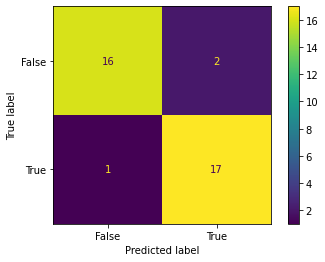

0.9166666666666666
52 ['Mor20m' 'Mor32m' 'Mor27v' 'nArOR' 'C-026' 'B05[N-F]' 'qnmax' 'ALOGP2'
 'CMC-80' 'Infective-80']


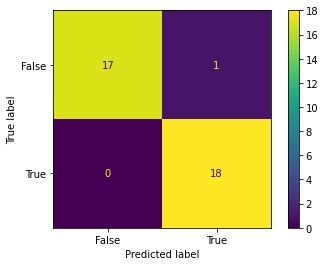

0.9722222222222222
53 ['EE_D' 'minssO' 'CATS2D_09_AP' 'B02[O-O]' 'B08[O-O]' 'B10[C-N]'
 'Depressant-80' 'Infective-80' 'MDEN-22' 's4_numAroBonds']


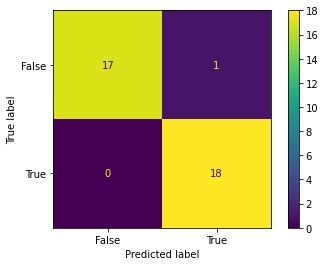

0.9722222222222222
54 ['nAA' 'P_VSA_charge_10' 'Mor25m' 'Mor32m' 'Mor27v' 'Mor32v' 'NaaaC'
 'ALOGP2' 'Infective-80' 's2_relPathLength']


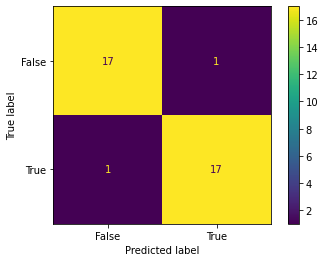

0.9444444444444444
55 ['SM03_EA(dm)' 'VE1sign_RG' 'Mor25m' 'Mor32m' 'Mor32v' 'B01[N-O]'
 'B09[Cl-Cl]' 'B10[C-N]' 'CMC-80' 's4_numAroBonds']


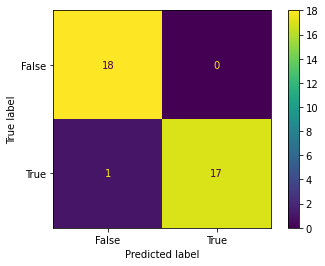

0.9722222222222222
56 ['nAA' 'Eta_sh_x' 'Mor32m' 'C-026' 'NssssC' 'minsCl' 'B02[O-O]' 'B07[N-O]'
 'CMC-80' 'Depressant-80']


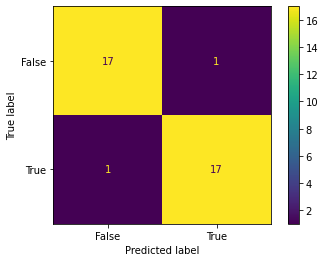

0.9444444444444444
57 ['Mor25m' 'Mor32m' 'NaaaC' 'B03[N-O]' 'B07[C-S]' 'B09[C-N]' 'B10[C-N]'
 'CMC-80' 'Neoplastic-80' 'nLevel3']


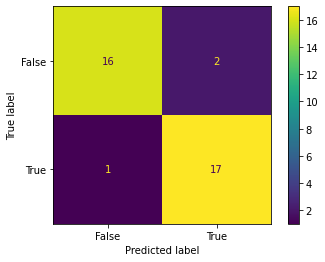

0.9166666666666666
58 ['PCD' 'VE1sign_X' 'VE1sign_D/Dt' 'VE1sign_RG' 'Mor32m' 'C-026' 'NaaaC'
 'ALOGP2' 'CMC-80' 'Infective-80']


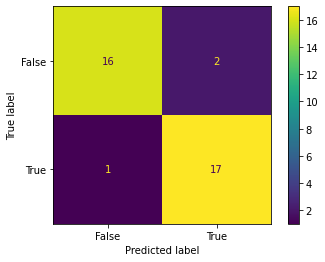

0.9166666666666666
59 ['Mor32m' 'Mor32v' 'NaaaC' 'B03[N-O]' 'B05[N-N]' 'B07[N-O]' 'B09[C-F]'
 'ALOGP2' 'CMC-80' 's4_numAroBonds']


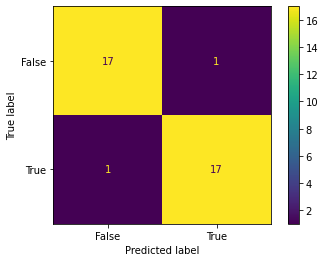

0.9444444444444444
60 ['Mor32m' 'Mor27v' 'B02[O-O]' 'B03[N-O]' 'B09[C-N]' 'B09[N-O]' 'B10[C-Cl]'
 'CMC-80' 'Infective-80' 's4_numAroBonds']


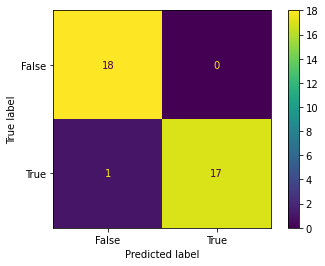

0.9722222222222222
61 ['P_VSA_ppp_L' 'Eta_sh_x' 'N-073' 'minsCl' 'CATS2D_04_AP' 'B03[N-O]'
 'B07[N-O]' 'B08[O-O]' 'CMC-80' 'Infective-80']


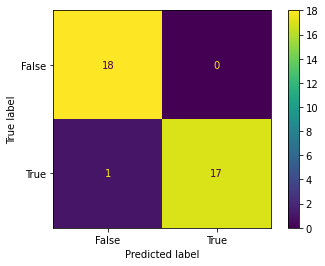

0.9722222222222222
62 ['nArOR' 'C-011' 'NaaaC' 'B03[N-N]' 'B04[N-O]' 'B06[O-O]' 'B09[C-N]'
 'B10[C-N]' 'Hypertens-80' 'Infective-80']


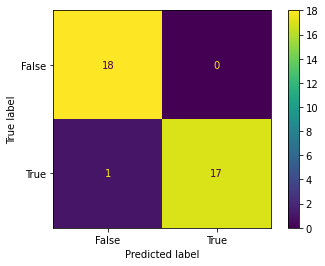

0.9722222222222222
63 ['P_VSA_charge_10' 'Mor32m' 'C-026' 'NaaaC' 'B04[N-O]' 'B06[O-O]'
 'B09[C-N]' 'B10[C-N]' 'B10[N-O]' 'CMC-80']


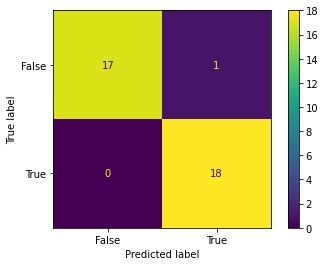

0.9722222222222222
64 ['Mor32u' 'Mor32m' 'Mor32v' 'B02[O-O]' 'B08[C-F]' 'B08[N-N]' 'B09[C-N]'
 'ALOGP2' 'Neoplastic-80' 'Infective-80']


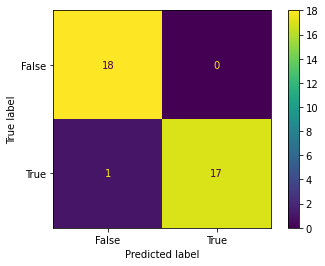

0.9722222222222222
65 ['Mor32m' 'B03[N-O]' 'B04[N-N]' 'B04[N-O]' 'B04[O-O]' 'B05[N-N]'
 'B09[C-N]' 'B10[C-N]' 'Hypertens-80' 'Infective-80']


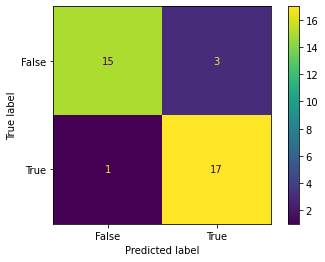

0.8888888888888888
66 ['P_VSA_charge_10' 'DISPp' 'Mor32m' 'SaaaC' 'NaaaC' 'B03[N-O]' 'B05[N-F]'
 'B06[O-O]' 'CMC-80' 'Infective-80']


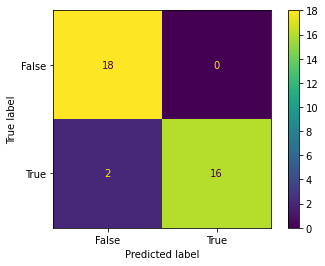

0.9444444444444444
67 ['Mor32m' 'nArOR' 'B01[N-O]' 'B09[C-N]' 'B09[N-O]' 'B09[Cl-Cl]' 'ALOGP2'
 'CMC-80' 'Infective-80' 'CATS3D_10_AL']


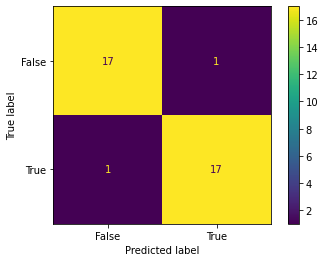

0.9444444444444444
68 ['EE_Dt' 'GATS5v' 'Mor18s' 'B03[N-O]' 'B09[C-N]' 'B09[C-Cl]' 'B10[C-N]'
 'CMC-80' 'Infective-80' 'CATS3D_12_DD']


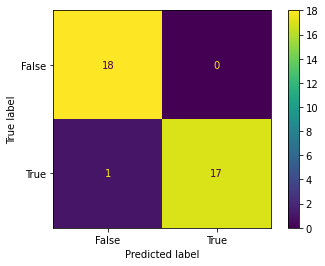

0.9722222222222222
69 ['nAA' 'Mor20m' 'Mor25m' 'NaaaC' 'B02[O-O]' 'B09[N-O]' 'ALOGP2' 'CMC-80'
 'Neoplastic-80' 'Infective-80']


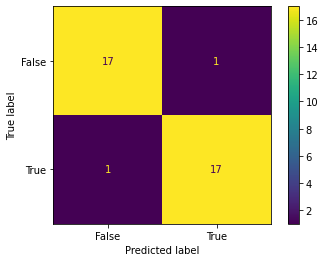

0.9444444444444444
70 ['VE1sign_X' 'Mor32m' 'NaaaC' 'B02[O-O]' 'B08[N-N]' 'B08[O-O]' 'B09[C-N]'
 'B10[C-N]' 'CMC-80' 'Infective-80']


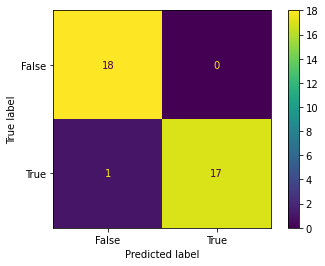

0.9722222222222222
71 ['PCR' 'P_VSA_charge_10' 'Mor27u' 'Mor20m' 'Mor17v' 'Mor27v' 'B03[N-N]'
 'B04[O-O]' 'CMC-80' 'Infective-80']


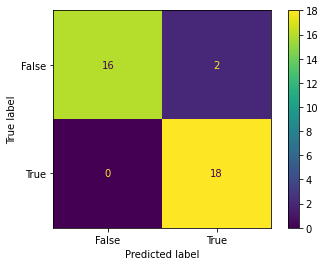

0.9444444444444444
72 ['Mor25m' 'C-026' 'SaaaC' 'NaaaC' 'B03[N-O]' 'B03[N-S]' 'B05[N-F]'
 'B08[O-O]' 'CMC-80' 'Infective-80']


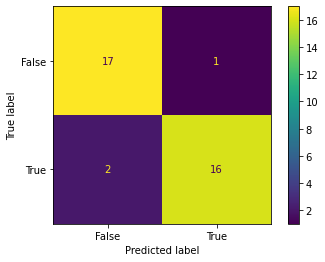

0.9166666666666666
73 ['Mor32m' 'Mor32v' 'SHED_NL' 'B03[N-O]' 'B05[N-F]' 'B07[N-N]' 'B09[C-N]'
 'MLOGP2' 'CMC-80' 'Infective-80']


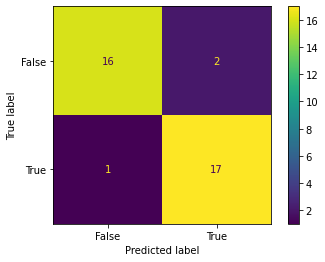

0.9166666666666666
74 ['Eta_sh_x' 'Mor32m' 'R6s+' 'B01[N-S]' 'B02[N-N]' 'B06[F-F]' 'B09[C-N]'
 'B10[C-N]' 'CMC-80' 'Infective-80']


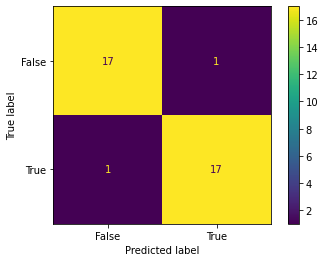

0.9444444444444444
75 ['P_VSA_ppp_L' 'Mor25m' 'Mor32m' 'Mor32v' 'C-003' 'B02[O-O]' 'ALOGP2'
 'CMC-80' 'Infective-80' 'nLevel3']


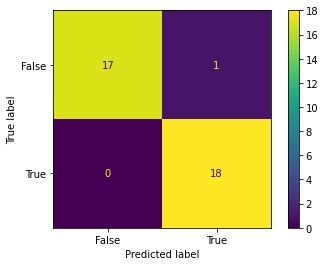

0.9722222222222222
76 ['nHM' 'VE1sign_X' 'P_VSA_charge_10' 'C-026' 'NaaaC' 'minssO' 'B08[O-O]'
 'CMC-80' 'Infective-80' 'WHALES60_Rem']


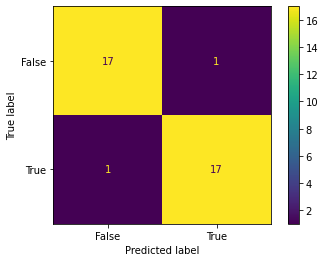

0.9444444444444444
77 ['nSpiro' 'VE1sign_X' 'Eta_sh_x' 'Mor25s' 'C-026' 'B09[C-N]' 'B10[C-N]'
 'CMC-80' 'Depressant-80' 'Infective-80']


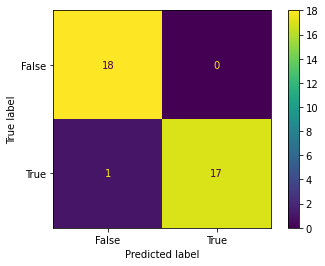

0.9722222222222222
78 ['VE1sign_B(s)' 'nArCONR2' 'nOHt' 'C-011' 'minssO' 'CATS2D_09_AP'
 'B03[N-O]' 'ALOGP2' 'Psychotic-80' 'Infective-80']


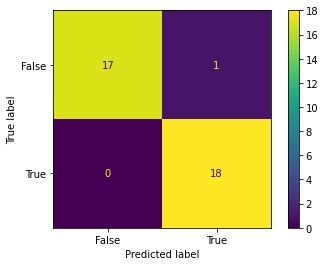

0.9722222222222222
79 ['VE1sign_X' 'SpMax1_Bh(v)' 'nArCONR2' 'NaaaC' 'B08[C-N]' 'B10[C-N]'
 'CMC-80' 'Neoplastic-80' 'Infective-80' 'nLevel6']


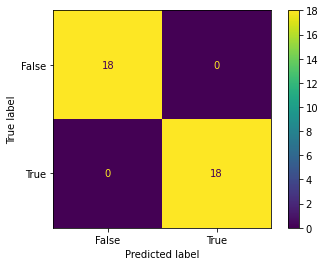

1.0
80 ['P_VSA_charge_10' 'C-026' 'B02[O-O]' 'B03[N-O]' 'B06[C-S]' 'B07[N-O]'
 'CMC-80' 'Infective-80' 'CATS3D_19_DL' 'nLevel6']


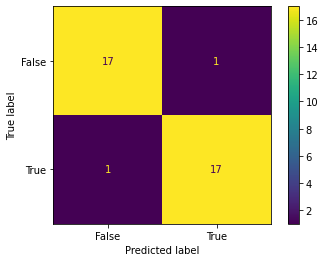

0.9444444444444444
81 ['VE1sign_X' 'P_VSA_charge_10' 'NaaaC' 'CATS2D_01_AA' 'B08[O-O]'
 'B09[C-N]' 'B10[C-N]' 'CMC-80' 'Depressant-80' 'Infective-80']


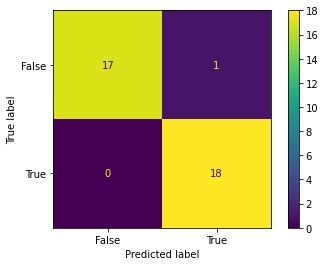

0.9722222222222222
82 ['P_VSA_charge_10' 'Mor25m' 'Mor32m' 'Mor27v' 'nCt' 'nArOR' 'C-026'
 'B08[O-O]' 'B10[C-N]' 'Infective-80']


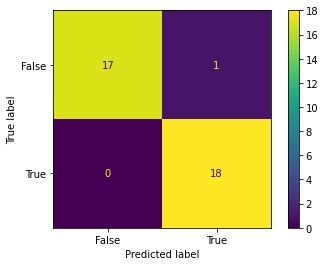

0.9722222222222222
83 ['VE1sign_RG' 'VE1sign_G/D' 'Mor32m' 'Mor30v' 'CATS2D_06_LL' 'B02[O-O]'
 'B03[N-S]' 'B10[C-Cl]' 'B10[O-O]' 'CMC-80']


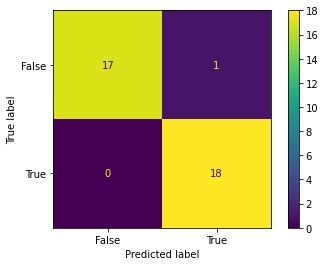

0.9722222222222222
84 ['nR07' 'VE1sign_X' 'P_VSA_charge_10' 'Mor30v' 'B02[O-O]' 'B03[N-O]'
 'B10[C-Cl]' 'B10[O-O]' 'Depressant-80' 'Infective-80']


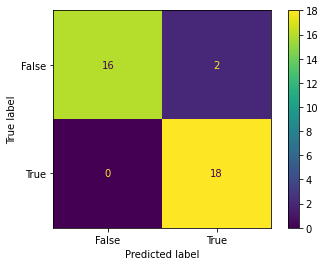

0.9444444444444444
85 ['nAA' 'VE1sign_RG' 'Mor32m' 'SaaaC' 'NaaaC' 'minsOH' 'B02[O-O]'
 'B03[N-S]' 'CMC-80' 'Infective-80']


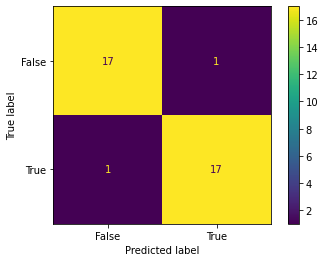

0.9444444444444444
86 ['Mor32m' 'C-026' 'B02[O-O]' 'B05[N-N]' 'B06[O-O]' 'B09[C-N]' 'B10[C-N]'
 'B10[O-O]' 'CMC-80' 'Infective-80']


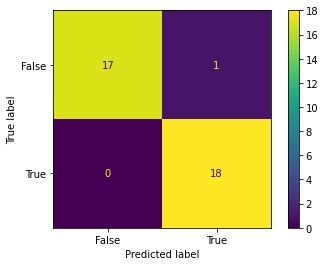

0.9722222222222222
87 ['nBnz' 'Mor32m' 'Mor18v' 'Mor32v' 'H-051' 'B03[N-N]' 'B05[N-F]'
 'B08[C-N]' 'B10[C-N]' 'Hypertens-80']


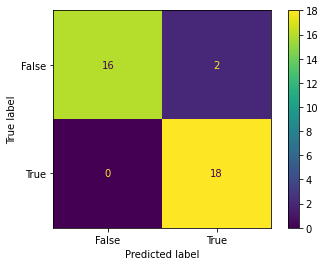

0.9444444444444444
88 ['EE_Dt' 'VE1sign_D/Dt' 'DISPi' 'Mor25m' 'Mor32m' 'NaaaC' 'B03[N-S]'
 'B04[O-O]' 'CMC-80' 'Infective-80']


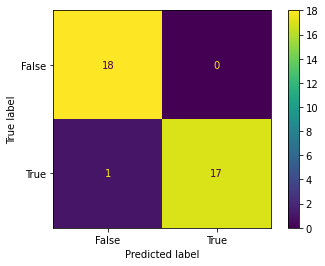

0.9722222222222222
89 ['Eta_sh_x' 'Mor17v' 'C-003' 'C-026' 'NaaaC' 'mindO' 'minsCl' 'B10[N-N]'
 'CMC-80' 'Neoplastic-80']


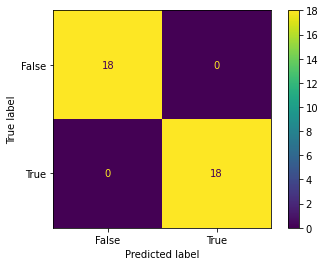

1.0
90 ['P_VSA_charge_10' 'SpMAD_EA(ri)' 'Mor25m' 'nArOR' 'B08[O-O]' 'B09[C-N]'
 'B09[N-F]' 'B10[C-Cl]' 'qnmax' 'Infective-80']


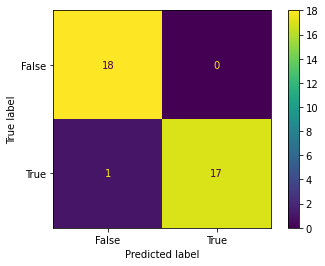

0.9722222222222222
91 ['SpMAD_L' 'VE1sign_X' 'NaaaC' 'B06[C-O]' 'B06[C-S]' 'B06[O-O]' 'B09[C-N]'
 'ALOGP2' 'Infective-80' 's3_numSharedNeighbors']


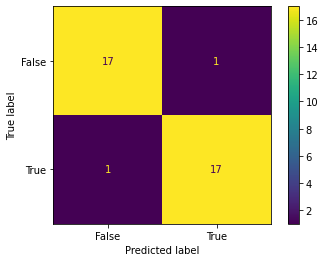

0.9444444444444444
92 ['Mor32m' 'NaaaC' 'B02[O-O]' 'B03[N-O]' 'B04[N-N]' 'B04[N-O]' 'B08[N-N]'
 'B10[C-N]' 'CMC-80' 'Infective-80']


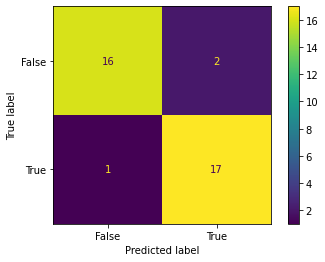

0.9166666666666666
93 ['P_VSA_charge_10' 'Mor25m' 'nCt' 'NaaaC' 'B02[O-O]' 'B09[N-F]' 'B10[C-C]'
 'CMC-80' 'Neoplastic-80' 'Infective-80']


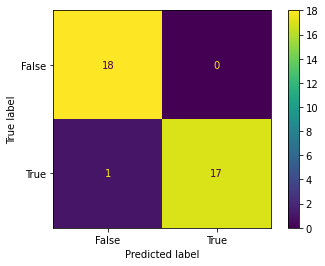

0.9722222222222222
94 ['nAA' 'SRW07' 'VE1sign_RG' 'Mor32m' 'Mor32v' 'minsCl' 'CATS2D_06_LL'
 'B07[N-S]' 'CMC-80' 'Depressant-80']


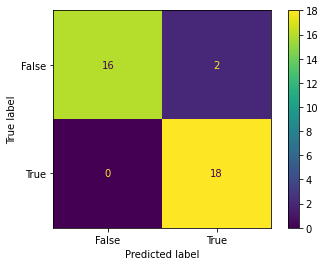

0.9444444444444444
95 ['VE1sign_X' 'P_VSA_charge_10' 'Mor32m' 'B05[N-F]' 'B09[C-N]' 'B09[N-O]'
 'B10[O-O]' 'ALOGP2' 'Depressant-80' 'Infective-80']


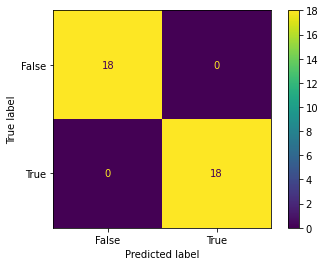

1.0
96 ['ARR' 'Mor25m' 'C-003' 'NaaaC' 'B02[O-O]' 'B08[N-N]' 'F02[O-O]'
 'Hypertens-80' 'Neoplastic-80' 'Infective-80']


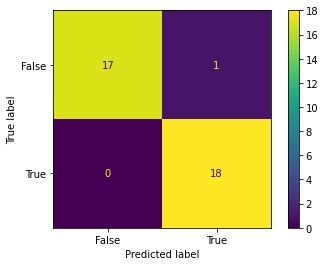

0.9722222222222222
97 ['EE_Dt' 'VE1sign_Dz(Z)' 'Mor20m' 'Mor32m' 'Mor32v' 'B02[O-O]' 'B04[O-O]'
 'B10[C-N]' 'CMC-80' 'Infective-80']


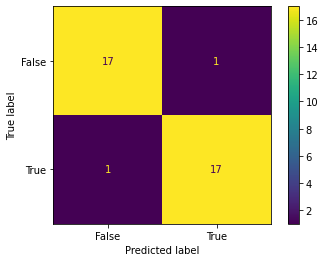

0.9444444444444444
98 ['NRS' 'nBnz' 'P_VSA_charge_10' 'Mor32m' 'Mor32v' 'NaaaC' 'B02[O-O]'
 'B03[N-O]' 'B05[N-F]' 'Infective-80']


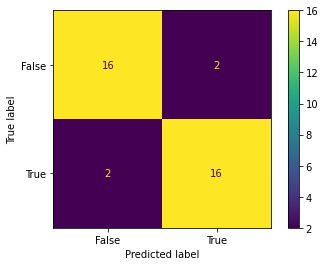

0.8888888888888888
99 ['VE1sign_D/Dt' 'VE1sign_Dz(Z)' 'Mor32m' 'Mor20v' 'Mor27v' 'B03[N-O]'
 'B09[C-F]' 'CMC-80' 'Neoplastic-80' 'Infective-80']


In [184]:
# try splitting into a bunch of random balanced fits and see which features show up frequently (can use LOO)

feat_r = []
for i in range(100):
    indices = y[y==False].sample(n=18).index
    X2 = pd.concat([x[y==True],x.loc[indices]])
    Y2 = pd.concat([y[y==True],y[indices]])
    clf.fit(X2,Y2)
    #cm_test(clf,X2,Y2)
    feat_r.append(feat_red(X2,Y2,10,'RFE',0))
    #N_best = feat_comp(clf,feat_r,X2,Y2)
    #print('N_best = ',N_best)
    clf.fit(X2[feat_r[i]],Y2)
    cm_test(clf,X2[feat_r[i]],Y2)
    print(i,feat_r[i])

<AxesSubplot:>

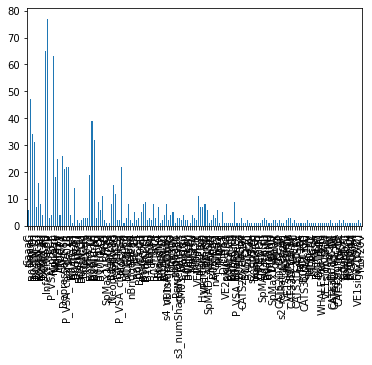

In [185]:
counts = pd.Series(np.stack(feat_r).flatten()).value_counts(sort=False)
counts.plot(kind='bar')

In [183]:
#counts.to_csv('descriptor_ranking.csv')
#counts = pd.read_csv('descriptor_ranking.csv')
#df = pd.read_csv('descriptor_ranking.csv', index_col=False, header=0);
#counts = df.set_index('Unnamed: 0')
#counts = counts.transpose()

0    1
Name: Mor21m, dtype: int64

In [178]:
desc_rank = counts.index

In [77]:
counts = pd.read_csv('descriptor_ranking.csv')


In [81]:
sum(counts['0']>9)

27

In [179]:
np.argmax(counts)

9

In [181]:
#counts['Mor32m']

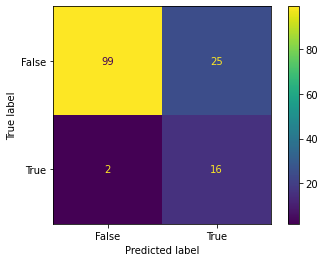

0.8436379928315412


In [25]:
descs=['Mor32m']

X_train2 = x[descs]

clf = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight='balanced')

#clf = DecisionTreeClassifier(class_weight='balanced',max_depth=2,min_samples_leaf=2)
clf.fit(X_train2,y)

predictions = clf.predict(X_train2)

cm = confusion_matrix(y, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

plt.show()

print(balanced_accuracy_score(y,clf.predict(X_train2)))

In [62]:
desc_best = []
for _ in range(10):
    scores_train = []
    scores_test = []
    descs = []
    for desc in desc_rank:
        #print(desc)
        descs = desc_best.copy()
        descs.append(desc)
   
        X_train2 = x[descs]

        clf = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight='balanced')

        clf.fit(X_train2,y)

        predictions = clf.predict(X_train2)
        predictions_test = clf.predict(test_molecules_2[descs])

        scores_train.append(balanced_accuracy_score(y,clf.predict(X_train2)))
        scores_test.append(balanced_accuracy_score(test_molecules_2['Experimental'],clf.predict(test_molecules_2[descs])))

        #print(balanced_accuracy_score(y,clf.predict(X_train2)))
    desc_best.append(desc_rank[np.argmax(scores_train)])
    print(desc_best,max(scores_train),scores_test[np.argmax(scores_train)])

['Mor32m'] 0.8436379928315412 0.425
['Mor32m', 'nR06'] 0.907258064516129 0.51875
['Mor32m', 'nR06', 'VE1sign_B(s)'] 0.9233870967741935 0.6125
['Mor32m', 'nR06', 'VE1sign_B(s)', 'P_VSA_LogP_6'] 0.9314516129032258 0.575
['Mor32m', 'nR06', 'VE1sign_B(s)', 'P_VSA_LogP_6', 'HATS6s'] 0.939516129032258 0.575
['Mor32m', 'nR06', 'VE1sign_B(s)', 'P_VSA_LogP_6', 'HATS6s', 'minaaNH'] 0.9435483870967742 0.575
['Mor32m', 'nR06', 'VE1sign_B(s)', 'P_VSA_LogP_6', 'HATS6s', 'minaaNH', 'B09[N-F]'] 0.9435483870967742 0.5125
['Mor32m', 'nR06', 'VE1sign_B(s)', 'P_VSA_LogP_6', 'HATS6s', 'minaaNH', 'B09[N-F]', 'B09[N-F]'] 0.9435483870967742 0.5125
['Mor32m', 'nR06', 'VE1sign_B(s)', 'P_VSA_LogP_6', 'HATS6s', 'minaaNH', 'B09[N-F]', 'B09[N-F]', 'B09[N-F]'] 0.9435483870967742 0.5125
['Mor32m', 'nR06', 'VE1sign_B(s)', 'P_VSA_LogP_6', 'HATS6s', 'minaaNH', 'B09[N-F]', 'B09[N-F]', 'B09[N-F]', 'B09[N-F]'] 0.9435483870967742 0.5125


In [ ]:
['Mor32m'] 0.8436379928315412
['Mor32m', 'Mor25m'] 0.8794802867383513
['Mor32m', 'Mor25m', 'ALOGP2'] 0.9274193548387097
['Mor32m', 'Mor25m', 'ALOGP2', 'VE1sign_RG'] 0.9314516129032258
['Mor32m', 'Mor25m', 'ALOGP2', 'VE1sign_RG', 'RDF040m'] 0.9435483870967742
['Mor32m', 'Mor25m', 'ALOGP2', 'VE1sign_RG', 'RDF040m', 'CATS3D_04_AP'] 0.9475806451612903
['Mor32m', 'Mor25m', 'ALOGP2', 'VE1sign_RG', 'RDF040m', 'CATS3D_04_AP', 'B10[N-N]'] 0.9475806451612903
['Mor32m', 'Mor25m', 'ALOGP2', 'VE1sign_RG', 'RDF040m', 'CATS3D_04_AP', 'B10[N-N]', 'nArCONR2'] 0.9516129032258065
['Mor32m', 'Mor25m', 'ALOGP2', 'VE1sign_RG', 'RDF040m', 'CATS3D_04_AP', 'B10[N-N]', 'nArCONR2', 'SpMAD_EA(ri)'] 0.9556451612903225
['Mor32m', 'Mor25m', 'ALOGP2', 'VE1sign_RG', 'RDF040m', 'CATS3D_04_AP', 'B10[N-N]', 'nArCONR2', 'SpMAD_EA(ri)', 'EE_G'] 0.9596774193548387

In [62]:
desc_best

['Mor32m', 'Mor25m']

In [48]:
desc_best = []
desc_best.append(desc_rank[np.argmax(scores)])

In [49]:
desc_best

['Mor32m']

In [35]:
desc_best.append(desc_rank[np.argmax(scores)])

AttributeError: 'str' object has no attribute 'append'

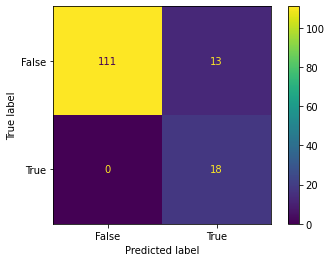

0.9475806451612903
0.8846153846153846


,Name,SMILES,experimental,prediction
0,Amiodarone,CCCCC1=C(C2=CC=CC=C2O1)C(=O)C3=CC(=C(C(=C3)I)O...,True,True
1,Apilimod,CC1=CC(=CC=C1)C=NNC2=CC(=NC(=N2)OCCC3=CC=CC=N3...,True,False
2,Chlorpromazine,CN(C)CCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl,True,True
3,Emetine,CCC1CN2CCC3=CC(=C(C=C3C2CC1CC4C5=CC(=C(C=C5CCN...,False,False
4,Emetine analog,CC[C@@H]1[C@@H](C[C@H](C2=C3)N(CCCCCCCC/C=C\CC...,True,True
5,Levofloxacin,CC1COC2=C3N1C=C(C(=O)C3=CC(=C2N4CCN(CC4)C)F)C(...,False,False
6,MC3,CCCCCC=CCC=CCCCCCCCCC(CCCCCCCCC=CCC=CCCCCC)OC(...,True,True
7,Netarsudil,CC1=CC(=C(C=C1)C(=O)OCC2=CC=C(C=C2)C(CN)C(=O)N...,True,False
8,Siramesine,C1CN(CCC12C3=CC=CC=C3CO2)CCCCC4=CN(C5=CC=CC=C5...,True,True
9,Sorafenib,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...,False,False


In [11]:
descs=['Mor32m']
descs = best5
X_train2 = X_reduced[descs]

clf = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight='balanced')

clf.fit(X_train2,Y)

predictions = clf.predict(X_train2)

cm = confusion_matrix(Y, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

plt.show()

print(balanced_accuracy_score(Y,clf.predict(X_train2)))

test_predict = clf.predict(test_molecules[X[descs].columns])
molecules['prediction'] = test_predict
molecules

print(sum(molecules['prediction']==molecules['experimental'])/len(molecules['prediction']))
molecules

In [101]:
desc_rank_10 = desc_rank[counts>9]
n = len(desc_rank_10)
scores = np.zeros((n,n))
i=0
j=0
for desc1 in desc_rank_10:
    j=0
    for desc2 in desc_rank_10:
        descs = [desc1,desc2]
   
        X_train2 = x[descs]

        clf = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight='balanced')
        clf.fit(X_train2,y)

        predictions = clf.predict(X_train2)
        scores[i,j] = balanced_accuracy_score(y,clf.predict(X_train2))
        j=j+1
    i=i+1

ind_best = np.asarray(np.unravel_index(scores.argmax(),scores.shape))
print('Maximum score of:',scores[ind_best[0],ind_best[1]],' for ',
      desc_rank_10[ind_best[0]],'&',
      desc_rank_10[ind_best[1]])

Maximum score of: 0.8794802867383513  for  Mor25m & Mor32m


In [82]:
freq_thresh = 9
max_desc = 5

best_scores = []
best_combs = []

for i in range(max_desc):
    print (i)
    [best_comb, best_score,best_test_score,_,_] = best_desc_comb(desc_rank,freq_thresh,i+1,x,y,test_molecules_2,test_molecules_2['Experimental'])
    best_combs.append(best_comb)
    best_scores.append(best_score)

'1294/17550'

KeyboardInterrupt: 

In [226]:
freq_thresh = 9
max_desc = 7

best_scores = []
best_combs = []

for i in range(max_desc):
    print (i)
    [best_comb, best_score,_,_] = best_desc_comb(desc_rank,freq_thresh,i+1)
    best_combs.append(best_comb)
    best_scores.append(best_score)

'657800/657800'

Maximum score of: 0.9556451612903225  for  ('B03[N-O]', 'B09[N-O]', 'Infective-80', 'Mor32m', 'B05[N-F]', 's4_numAroBonds', 'B08[O-O]')


In [97]:
best_comb_scores = pd.DataFrame()
best_comb_scores['Descriptors'] = best_combs
best_comb_scores['Scores'] = best_scores
best_comb_scores

,Descriptors,Scores
0,[Mor32m],0.843638
1,"[Mor32m, Mor25m]",0.879480
2,"[Mor32m, ALOGP2, VE1sign_RG]",0.939516


In [69]:
best1 = ['Mor32m']
best2 = ['Mor32m', 'Mor25m']
best3 = ['Mor32m', 'ALOGP2', 'VE1sign_RG']
best4 = ['Mor32m', 'ALOGP2', 'B05[N-F]', 'VE1sign_RG']
best5 = ['Mor32m', 'NaaaC', 'ALOGP2', 'VE1sign_RG', 'B04[N-O]']
best6 = ['B03[N-O]', 'Infective-80', 'Mor32m', 'B05[N-F]', 's4_numAroBonds', 'B08[O-O]']
best7 = ['B03[N-O]', 'B09[N-O]', 'Infective-80', 'Mor32m', 'B05[N-F]', 's4_numAroBonds', 'B08[O-O]']

In [131]:
desc_sel = best4
clf.fit(x[desc_sel],y)
print(balanced_accuracy_score(test_molecules_2['Experimental'],clf.predict(test_molecules_2[desc_sel])))

0.86875


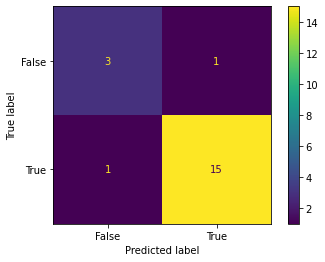

0.84375


In [76]:
desc_sel = best5
clf.fit(x[desc_sel],y)
predictions = clf.predict(test_molecules_3[desc_sel])
cm = confusion_matrix(test_molecules_3['Experimental'], predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

plt.show()
#print(balanced_accuracy_score(test_molecules_3['Experimental'],clf.predict(test_molecules_3[feat_r[N_best]])))
print(balanced_accuracy_score(test_molecules_3['Experimental'],clf.predict(test_molecules_3[desc_sel])))


In [11]:
balanced_accuracy_score

<function sklearn.metrics._classification.balanced_accuracy_score(y_true, y_pred, *, sample_weight=None, adjusted=False)>

In [13]:
molecules

,Name,SMILES,prediction
0,Amiodarone,CCCCC1=C(C2=CC=CC=C2O1)C(=O)C3=CC(=C(C(=C3)I)O...,True
1,Apilimod,CC1=CC(=CC=C1)C=NNC2=CC(=NC(=N2)OCCC3=CC=CC=N3...,False
2,Chlorpromazine,CN(C)CCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl,False
3,Emetine,CCC1CN2CCC3=CC(=C(C=C3C2CC1CC4C5=CC(=C(C=C5CCN...,True
4,Emetine analog,CC[C@@H]1[C@@H](C[C@H](C2=C3)N(CCCCCCCC/C=C\CC...,False
5,Levofloxacin,CC1COC2=C3N1C=C(C(=O)C3=CC(=C2N4CCN(CC4)C)F)C(...,False
6,MC3,CCCCCC=CCC=CCCCCCCCCC(CCCCCCCCC=CCC=CCCCCC)OC(...,False
7,Netarsudil,CC1=CC(=C(C=C1)C(=O)OCC2=CC=C(C=C2)C(CN)C(=O)N...,True
8,Siramesine,C1CN(CCC12C3=CC=CC=C3CO2)CCCCC4=CN(C5=CC=CC=C5...,True
9,Sorafenib,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...,True


In [14]:
molecules['experimental'] = [True,True,True,False,True,False,True,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True]

In [28]:
sum(molecules['prediction']==molecules['experimental'])/len(molecules['prediction'])

0.34615384615384615

In [19]:
molecules

,Name,SMILES
0,Amiodarone,CCCCC1=C(C2=CC=CC=C2O1)C(=O)C3=CC(=C(C(=C3)I)O...
1,Apilimod,CC1=CC(=CC=C1)C=NNC2=CC(=NC(=N2)OCCC3=CC=CC=N3...
2,Chlorpromazine,CN(C)CCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl
3,Emetine,CCC1CN2CCC3=CC(=C(C=C3C2CC1CC4C5=CC(=C(C=C5CCN...
4,Emetine analog,CC[C@@H]1[C@@H](C[C@H](C2=C3)N(CCCCCCCC/C=C\CC...
5,Levofloxacin,CC1COC2=C3N1C=C(C(=O)C3=CC(=C2N4CCN(CC4)C)F)C(...
6,MC3,CCCCCC=CCC=CCCCCCCCCC(CCCCCCCCC=CCC=CCCCCC)OC(...
7,Netarsudil,CC1=CC(=C(C=C1)C(=O)OCC2=CC=C(C=C2)C(CN)C(=O)N...
8,Siramesine,C1CN(CCC12C3=CC=CC=C3CO2)CCCCC4=CN(C5=CC=CC=C5...
9,Sorafenib,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...


In [13]:
descs=best5

X_train2 = X_reduced[descs]

clf = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight='balanced')

clf.fit(X_train2,Y)

pickle.dump(clf, open("best_model.p", "wb"))
pickle.dump(descs, open("best_features.p","wb"))
pickle.dump(scaler, open("scaler.p","wb"))
pickle.dump(X, open("X.p","wb"))
pickle.dump(data,open("data.p","wb"))

In [10]:
data

,SMILES,CASRN,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,...,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment,RG,Group,RG_binary
0,[H][C@]12C[C@@H](OC(=O)C3=CC(OC)=C(OC)C(OC)=C3...,50-55-5,Reserpine,608.8,7.247,51.49,84.94,53.57,94.77,0.6129,...,6.667,34.17,0.7765,9.000,0.20450,30.00,8.249,0.707069,1,False
1,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,83905-01-5,Azithromycin,749.1,6.041,67.06,124.10,72.11,142.00,0.5408,...,0.000,48.08,0.9247,13.030,0.25050,58.19,15.960,1.054428,1,False
2,ClC1=CC=CC=C1CN1CCC2=C(C1)C=CS2,55142-85-3,Ticlopidine,263.8,8.510,20.72,30.69,22.84,34.27,0.6685,...,0.000,0.00,0.0000,0.000,0.00000,0.00,0.000,1.057829,1,False
3,CN(C)CCCC1(OCC2=C1C=CC(=C2)C#N)C1=CC=C(F)C=C1,59729-33-8,Citalopram,324.4,7.210,28.41,44.88,30.02,50.70,0.6313,...,6.000,15.00,0.6250,1.000,0.04167,9.11,1.732,1.015802,1,False
4,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...,159989-64-7,Nelfinavir,567.9,6.681,50.17,84.25,54.47,95.97,0.5903,...,9.600,35.10,0.8775,6.800,0.17000,37.32,7.605,1.156914,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,CC1=CC(C)=C(Br)C(C)=C1NC(=O)CN(CC(O)=O)CC(O)=O,78266-06-5,Mebrofenin,387.3,9.220,26.38,43.02,27.49,47.62,0.6282,...,0.000,0.00,0.0000,0.000,0.00000,0.00,0.000,1.127932,6,False
138,[H][C@]12CCC[C@H](N1C(=O)[C@H](CCS2)NC(=O)[C@@...,167305-00-2,Omapatrilat,408.6,8.012,32.07,51.39,34.50,57.24,0.6288,...,4.500,23.75,0.8796,6.000,0.22220,28.61,8.513,1.091463,6,False
139,[H][C@@]12CC3=C(C(O)=CC=C3)C(=O)C1=C(O)[C@]1(O...,15866-90-7,Incyclinide,371.4,8.440,29.24,45.46,29.28,49.29,0.6645,...,3.333,19.83,0.7346,6.667,0.24690,16.41,6.644,0.890418,6,False
140,NC1=CC=C(C=C1)S(=O)(=O)NC(=O)C1=CC=CC=C1,127-71-9,Sulfabenzamide,276.3,8.914,21.01,31.68,21.83,34.62,0.6777,...,0.000,0.00,0.0000,0.000,0.00000,0.00,0.000,1.012424,6,False


In [ ]:
# save features from best model
# best5 = ['Mor32m', 'NaaaC', 'ALOGP2', 'VE1sign_RG', 'B04[N-O]']
